# MIS 583 Assignment 6: Text Sentiment Classification with Prompt Learning

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷, M114020035

**Your Answer:**   
Hi I'm 鄔仁迪, B104020009

## Overview

**Sentiment Classification** is an automated process of identifying opinions in text and labeling them as positive or negative based on the emotions customers express within them.

In Task 1, you need to fine-tune a pre-trained language model (e.g., BERT) to predict the sentiment of given tweets.

In Task 2, we employ prompts to enable the model to perform sentiment analysis through in-context learning, eliminating the need for additional training.

In Task 3, you will use the method called LM-BFF to utilize the model in generating the optimal template and verbalizer autonomously.


# Notice
**You are not allow to use the model like GPT family or pre-trained weight using SST-2 and twitter dataset!!!!!!!!!!!!!!!!!**

You can use BERT and RoBERTa encoder model

##  Versions of used packages

We will check PyTorch version to make sure everything work properly.  
We use `python==3.7.14`, `torch==1.12.1+cu113` and `torchvision==0.13.1+cu113`.  
This is the default version in Google Colab.

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]
torch 2.1.0+cu118
torchvision 0.16.0+cu118


# Task 1: Text Sentiment Classification (40 points)

In this task, you need to fine-tune a pre-trained language model (e.g., BERT or RoBERTa encoder) to predict the sentiment of given tweets.


## Loading Model and Data

First, let's talk about the model. The Hugging Face team has created an amazing framework called "transformers" for NLP tasks. It includes many state-of-the-art machine learning models for PyTorch, TensorFlow, and JAX.

To start with this package, follow [this link to installation and a basic tutorial](https://pytorch.org/hub/huggingface_pytorch-transformers/).

In [ ]:
# you might need some additional installations there
"""!echo happy installation
!pip -V
!pip install grpcio
!pip install google-auth
!pip install protobuf==3.9.2
!pip install pyprind
!pip install tqdm boto3 requests regex sentencepiece sacremoses"""

'!echo happy installation\n!pip -V\n!pip install grpcio\n!pip install google-auth\n!pip install protobuf==3.9.2\n!pip install pyprind\n!pip install tqdm boto3 requests regex sentencepiece sacremoses'

In [ ]:
from torch import nn

#########################################################################
#            Loading tokenizer and model from transformer               #
#########################################################################
from transformers import AutoTokenizer, RobertaForSequenceClassification, AutoConfig

bert_type = 'roberta-base'

# ---------- 1. load from torch.hub ----------
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# create a Bert-extended task (classification)
model = RobertaForSequenceClassification.from_pretrained(bert_type)

# finetune from the output from bert to your task
# Replace the out_proj layer in the classifier with a new Linear layer for 3 classes
model.classifier.out_proj = nn.Linear(in_features=768, out_features=3, bias=True)
#########################################################################
#                          End of your code                             #
#########################################################################

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## How to Get Data

Please open the file `twitter_sentiment.zip`, creat shortcut to your Google Drive.

1. open [LINK of Google Drive](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. Click "Add shortcut to Drive" in the top-right corner.
3. Select the location where you want to place the shortcut.
4. Click Add shortcut.

After above procedures, we have a shortcut of zip file of dataset.  
We can access this in colab after granting the permission of Google Drive.

---

請先到共用雲端硬碟將檔案 `twitter_sentiment.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/19Ty2lVAm55VL5QIM-MMQhhOzWXeMtxeV/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Unzip Data

解壓縮 `twitter_sentiment.zip` 後可以發現裡面有三個csv檔。

- `train.csv`, `test.csv` and `val.csv`

Training set 有 **10248** 筆資料.  
Validation set 有 **1317** 筆資料.  
Testing set 有 **3075** 筆資料.  

注意: 若有另外設定存放在雲端硬碟中的路徑，請記得本處路徑也須做更動。

In [ ]:
# !unzip -qq ./drive/MyDrive/twitter_sentiment.zip

In [ ]:
# Utility function to extract text and label from csv file
def get_texts(f_name='./twitter_sentiment', mode='train'):
    text_list = []
    label_list = []

    f_path = os.path.join(f_name, '{}.csv'.format(mode))
    with open(f_path, encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for line in reader:
            text_list.append(line['text'])
            if mode != 'test':
                label_list.append(int(line['sentiment_label']))

    return text_list, label_list

In [ ]:
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):
    def __init__(self, f_name='./twitter_sentiment', mode='train'):
        self.mode = mode

        text_list, label_list = get_texts(f_name, mode)
        print('mode', mode, 'has', len(text_list), 'datas')
        text_list = tokenizer(text_list,
                             truncation=True, padding=True,
                             return_tensors='pt')

        self.text_list = text_list['input_ids']
        self.mask_list = text_list['attention_mask']

        self.label_list = label_list

    def __getitem__(self, idx):
        text = self.text_list[idx]
        mask = self.mask_list[idx]
        if self.mode == 'test':
            return text, mask
        label = torch.tensor(self.label_list[idx])
        return text, mask, label

    def __len__(self):
        return len(self.text_list)

In [ ]:
dataset_train = TwitterDataset(mode='train')
dataset_val = TwitterDataset(mode='val')
dataset_test = TwitterDataset(mode='test')

batch_size = 32
train_data = DataLoader(dataset_train, batch_size=batch_size,
                       shuffle=True)
val_data = DataLoader(dataset_val, batch_size=batch_size // 2,
                       shuffle=False)
test_data = DataLoader(dataset_test, batch_size=batch_size // 2,
                       shuffle=False)

mode train has 10248 datas
mode val has 1317 datas
mode test has 3075 datas


In [ ]:
t = tokenizer.convert_ids_to_tokens(dataset_train[0][0])
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t))

token ['<s>', '@', 'united', 'ĠI', 'Ġhave', 'Ġnever', 'Ġbeen', 'Ġmislead', 'Ġby', 'Ġa', 'Ġcompany', 'Ġas', 'Ġmany', 'Ġtimes', 'Ġas', 'ĠI', 'Ġhave', 'Ġthis', 'Ġweek', 'Ġby', 'ĠUnited', 'ĠAirlines', '!', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

In [ ]:
device = torch.device('cuda')

from torch import nn
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# 定義標籤平滑化的KL損失函數 Paper: https://arxiv.org/pdf/2312.06522.pdf
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = -1

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

# 設定標籤平滑化水平
"""
LS2: smoothing=0.03（即3%平滑化）
LS3: smoothing=0.075（即7.5%平滑化）
LS4: smoothing=0.15（即15%平滑化）
LS5: smoothing=0.3（即30%平滑化）
"""
criterion = LabelSmoothingLoss(classes=3, smoothing=0.075)

model = model.to(device)
criterion = criterion.to(device)

## Utility Function

In [ ]:
def accuracy(raw_preds, y):
    preds = raw_preds.argmax(dim=1)
    acc = (preds == y).sum()
    return acc

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

train_loss_list = []
val_loss_list = []

def train(model, data, optimizer, criterion):
    model.train()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Testing process                              #
        #########################################################################
        # 1. Clean the gradients of optimizer
        # 2. Put correct variables into model
        # 3. Get prediction
        # 4. Evalutate by criterion and accuracy

        # Clean the gradients of optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(text, attention_mask=mask)

        # Compute loss
        loss = criterion(outputs.logits, label)

        # Compute accuracy using the provided function
        acc = accuracy(outputs.logits, label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

def test(model, data, criterion, log_loss=False):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0
    total = 0
    for text, mask, label in tqdm(data, total=len(data)):
        text = text.to(device)
        mask = mask.to(device)
        label = label.to(device)

        #########################################################################
        #                          Training process                             #
        #########################################################################
        # 1. Put correct variables into model
        # 2. Get prediction
        # 3. Evalutate by criterion and accuracy

        # No gradient calculation for evaluation
        with torch.no_grad():
            # Forward pass
            outputs = model(text, attention_mask=mask)

            # Compute loss
            loss = criterion(outputs.logits, label)

            # Compute accuracy
            acc = accuracy(outputs.logits, label)
        #########################################################################
        #                          End of your code                             #
        #########################################################################

        epoch_loss += loss.item()
        if log_loss:
            val_loss_list.append(loss.item())
        epoch_acc += acc.item()
        total += len(text)
    return epoch_loss / total, epoch_acc / total

# class for monitoring train and test acc/loss
class Meter:
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []

    def update(self, train_loss, train_acc, val_loss, val_acc):
        self.train_loss_list.append(train_loss)
        self.train_acc_list.append(train_acc)
        self.val_loss_list.append(val_loss)
        self.val_acc_list.append(val_acc)

    def plot(self):
        x = range(len(self.train_loss_list))
        plt.plot(x, self.train_loss_list)
        plt.plot(x, self.val_loss_list, color='r')
        plt.legend(['train_loss', 'val_loss'])
        plt.show()
        plt.plot(x, self.train_acc_list)
        plt.plot(x, self.val_acc_list, color='r')
        plt.legend(['train_acc', 'val_acc'])
        plt.show()

## Start Training

In [ ]:
#########################################################################
#                          Hyper-parameters                             #
#########################################################################
max_epoch = 5
log_interval = 1
best_acc = 0
#########################################################################
#                          End of your code                             #
#########################################################################

m = Meter()

for epoch in range(1, max_epoch + 1):
    train_loss, train_acc = train(model, train_data, optimizer, criterion)
    val_loss, val_acc = test(model, val_data, criterion, log_loss=True)

    if epoch % log_interval == 0:
        print('Epoch {} train_loss: {} train_acc: {}'.format(
            epoch, train_loss, train_acc
        ))
        print('Epoch {} val_loss:  {} val_acc : {}'.format(
            epoch, val_loss, val_acc
        ))

    m.update(train_loss, train_acc, val_loss, val_acc)

    # model checkpoint
    if val_acc > best_acc:
        best_model = model
        best_acc = val_acc
        print('-'*10, 'e', epoch, 'save best model', '-'*10)
        torch.save(model.state_dict(), 'ckpts/e{}.pt'.format(epoch))

100%|██████████| 83/83 [00:05<00:00, 15.20it/s]


Epoch 1 train_loss: 0.021190216626672424 train_acc: 0.7865925058548009
Epoch 1 val_loss:  0.03611378207655684 val_acc : 0.856492027334852
---------- e 1 save best model ----------


100%|██████████| 83/83 [00:05<00:00, 16.01it/s]


Epoch 2 train_loss: 0.01728838843865659 train_acc: 0.8663153786104606
Epoch 2 val_loss:  0.03550267371157398 val_acc : 0.8549734244495064


100%|██████████| 83/83 [00:06<00:00, 12.73it/s]


Epoch 3 train_loss: 0.016003124642707145 train_acc: 0.8943208430913349
Epoch 3 val_loss:  0.036412288247407526 val_acc : 0.8602885345482156
---------- e 3 save best model ----------


100%|██████████| 83/83 [00:06<00:00, 12.58it/s]


Epoch 4 train_loss: 0.014820262336060928 train_acc: 0.917447306791569
Epoch 4 val_loss:  0.037863983018161136 val_acc : 0.8587699316628702


100%|██████████| 83/83 [00:06<00:00, 12.68it/s]

Epoch 5 train_loss: 0.013743110239552297 train_acc: 0.9374512099921936
Epoch 5 val_loss:  0.03764960034018497 val_acc : 0.8602885345482156


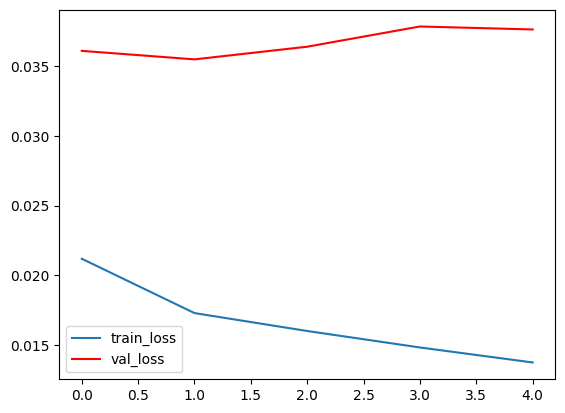

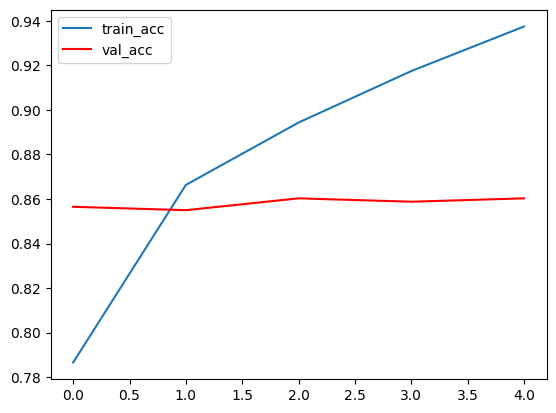

In [ ]:
# plot them out
m.plot()

## Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/f072e95f51bc48978225941dba218241).


In [ ]:
best_model = model
best_model.load_state_dict(torch.load('ckpts/e1.pt'))

<All keys matched successfully>

In [ ]:
best_model.eval()

total_out = []
for text, mask in tqdm(test_data, total=len(test_data)):
    text = text.to(device)
    mask = mask.to(device)

    output = best_model(text, mask)
    pred = output.logits
    pred = torch.argmax(pred, dim=1)
    total_out.append(pred)

total_out = torch.cat(total_out).cpu().numpy().tolist()

with open('pred.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(total_out):
        f.write('{},{}\n'.format(i, pred))

100%|██████████| 193/193 [00:14<00:00, 13.43it/s]


In [ ]:
# Save best model
torch.save(best_model.state_dict(), 'ckpts/best_model.pt')

# Task 2: In-Context learning (32 points)

In this task, you will learn how to perform sentiment classification using prompts without the need for training.

In [ ]:
import torch
import pyprind
import numpy as np
import pandas as pd
import torch.nn as nn
from transformers import BertConfig, BertTokenizer, BertForMaskedLM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Loading model and setup

In [ ]:
#########################################################################
#         TODO: Design your own template(prefix) and verbalizer         #
#########################################################################
class Config:
    def __init__(self):
        # Zero-shot learning template
        # self.prefix = "Sentence for emotion: This sentence is [MASK]."

        # One-shot learning template
        # self.prefix = (
        #     "Sentence for emotion: This sentence is negative. @united be worse?oh you can't! delayed with no reason on the way to Lon. [SEP] "
        #     "Sentence for emotion: This sentence is [MASK]."
        # )

        # Few-shot learning template
        self.prefix = (
            "Sentence for emotion: This sentence is negative. @united be worse?oh you can't! delayed with no reason on the way to Lon. [SEP] "
            "Sentence for emotion: This sentence is neutral. @AmericanAir what's the best number to use? [SEP] "
            "Sentence for emotion: This sentence is positive. @JetBlue I was so excited when I saw that you fly there! #ionlyflyblue. [SEP] "
            "Sentence for emotion: This sentence is [MASK]."
        )

        self.verbalizer = {
            'negative': 0,
            'neutral': 1,
            'positive': 2,
        }

        self.max_seq_length = 512
        self.batch_size = 32


config = Config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_type = 'bert-base-uncased'

model = BertForMaskedLM.from_pretrained(bert_type, num_labels=3)

tokenizer = BertTokenizer.from_pretrained(bert_type)

bert_config = BertConfig.from_pretrained(bert_type)

bert = model.from_pretrained(bert_type, config=bert_config).to(device)

#######################################################################
#                        End of your code                             #
#######################################################################

softmax = nn.Softmax(dim=1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model t

In [ ]:
# Utility function to obtaion verbalizer ids
def obtain_verbalizer_ids(verbalizer, tokenizer):
    verbalizer_ids = tokenizer.convert_tokens_to_ids(list(verbalizer.keys()))
    index2ids = {i: verbalizer_ids[i] for i in range(len(verbalizer_ids))}
    return verbalizer_ids, index2ids

In [ ]:
verbalizer_ids, index2ids = obtain_verbalizer_ids(config.verbalizer, tokenizer)

In [ ]:
# Utility function to concatenate prefix and text
def concatenate_prefix(texts, config):
    ##################################################
    #   TODO: concatenate your own prefix and text   #
    ##################################################
    prefix_texts = [config.prefix + " " + text for text in texts]
    ##################################################
    #                 End of your code               #
    ##################################################
    return prefix_texts

In [ ]:
def load_data(config):
    # ['texts', 'labels']
    df = pd.read_csv('./twitter_sentiment/train.csv')
    original_texts = df['text'].tolist()
    labels = df['sentiment_label'].tolist()

    texts = concatenate_prefix(original_texts, config)

    return texts, labels


texts, labels = load_data(config)

In [ ]:
t = tokenizer.convert_ids_to_tokens(tokenizer.encode(texts[0], add_special_tokens=True))
print('token', t)
print('token to s', tokenizer.convert_tokens_to_string(t))

token ['[CLS]', 'sentence', 'for', 'emotion', ':', 'this', 'sentence', 'is', 'negative', '.', '@', 'united', 'be', 'worse', '?', 'oh', 'you', 'can', "'", 't', '!', 'delayed', 'with', 'no', 'reason', 'on', 'the', 'way', 'to', 'lo', '##n', '.', '[SEP]', 'sentence', 'for', 'emotion', ':', 'this', 'sentence', 'is', 'neutral', '.', '@', 'americana', '##ir', 'what', "'", 's', 'the', 'best', 'number', 'to', 'use', '?', '[SEP]', 'sentence', 'for', 'emotion', ':', 'this', 'sentence', 'is', 'positive', '.', '@', 'jet', '##bl', '##ue', 'i', 'was', 'so', 'excited', 'when', 'i', 'saw', 'that', 'you', 'fly', 'there', '!', '#', 'ion', '##ly', '##fly', '##bl', '##ue', '.', '[SEP]', 'sentence', 'for', 'emotion', ':', 'this', 'sentence', 'is', '[MASK]', '.', '@', 'united', 'i', 'have', 'never', 'been', 'mis', '##lea', '##d', 'by', 'a', 'company', 'as', 'many', 'times', 'as', 'i', 'have', 'this', 'week', 'by', 'united', 'airlines', '!', '[SEP]']
token to s [CLS] sentence for emotion : this sentence is ne

In [ ]:
# Batching of texts and labels for training or processing in batches
def pack_batch(texts, labels, batch_size):
    """
    :param texts: list
    :param labels: list
    :param batch_size: int
    :return batch_X: list
            [[text11, text12, ...], [text21, text22, ...], ...]
    :return batch_y: list
            [[label11, label12, ...], [label21, label22, ...], ...]
    :return batch_count: int
    """
    assert len(texts) == len(labels)

    if len(texts) % batch_size != 0:
        flag = False
        batch_count = int(len(texts) / batch_size) + 1
    else:
        flag = True
        batch_count = int(len(texts) / batch_size)

    batch_X, batch_y = [], []

    if flag:
        for i in range(batch_count):
            batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
            batch_y.append(labels[i * batch_size: (i + 1) * batch_size])
    else:
        for i in range(batch_count):
            if i == batch_count - 1:
                batch_X.append(texts[i * batch_size:])
                batch_y.append(labels[i * batch_size:])
            else:
                batch_X.append(texts[i * batch_size: (i + 1) * batch_size])
                batch_y.append(labels[i * batch_size: (i + 1) * batch_size])

    return batch_X, batch_y, batch_count

In [ ]:
batch_X, batch_y, batch_count = pack_batch(texts, labels, config.batch_size)

In [ ]:
with torch.no_grad():
    predict_all = np.array([], dtype=int)
    labels_all = np.array([], dtype=int)
    pper = pyprind.ProgPercent(batch_count)
    for i in range(batch_count):
        inputs = batch_X[i]
        labels = batch_y[i]

        tokens = tokenizer.batch_encode_plus(inputs, add_special_tokens=True,
                                             max_length=config.max_seq_length,
                                             padding='max_length', truncation=True)

        ids = torch.tensor(tokens['input_ids']).to(device)
        attention_mask = torch.tensor(tokens['attention_mask']).to(device)

        # Shape: (batch_size, max_seq_length, vocab_size)
        logits = bert(ids, attention_mask=attention_mask).logits

        mask_token_index = (ids == tokenizer.mask_token_id).nonzero(as_tuple=True)

        # Find [MASK] logits
        # shape: (batch_size, vocab_size)
        masked_logits = logits[mask_token_index[0], mask_token_index[1], :]

        # Extract the logits of the word in the verbalizer at the [MASK] position
        # shape: (batch_size, verbalizer_size)
        verbalizer_logits = masked_logits[:, verbalizer_ids]

        # Construct a pseudo-distribution from the logits in these verbalizers
        pseudo_distribution = softmax(verbalizer_logits)

        #################################################################################
        #   1. Find the index with the maximum probability in the pseudo-distribution   #
        #   2. Convert the index to the corresponding word ID                           #
        #   3. Convert the ID to a token                                                #
        #   4. Find the label corresponding to the token                                #
        #################################################################################
        # 1. Find the index with the maximum probability in the pseudo-distribution
        pred_indices = torch.argmax(pseudo_distribution, dim=1)

        # 2. Convert the index to the corresponding word ID
        pred_ids = [verbalizer_ids[index] for index in pred_indices]

        # 3. Convert the ID to a token
        pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids)

        # 4. Find the label corresponding to the token
        pred_labels = [config.verbalizer[token] if token in config.verbalizer else -1 for token in pred_tokens]
        pred_labels = np.array(pred_labels)
        #################################################################################
        #                             End of your code                                  #
        #################################################################################

        predict_all = np.append(predict_all, pred_labels)
        labels_all = np.append(labels_all, labels)

        pper.update()

    acc = accuracy_score(labels_all, predict_all)
    p = precision_score(labels_all, predict_all, average="weighted")
    r = recall_score(labels_all, predict_all, average="weighted")
    f1 = f1_score(labels_all, predict_all, average="weighted")

    print('accuracy: %f | precision: %f | recall: %f | f1: %f' % (acc, p, r, f1))

[100 %] Time elapsed: 00:05:04 | ETA: 00:00:00

accuracy: 0.696331 | precision: 0.651213 | recall: 0.696331 | f1: 0.637934



Total time elapsed: 00:05:04


In [ ]:
pd.DataFrame([labels_all, predict_all]).T[1].value_counts()

1
1    10248
Name: count, dtype: int64

# Task 3: LM-BFF (45 points)

https://arxiv.org/pdf/2012.15723.pdf

Unlike the previous task, LM-BFF can generate templates and verbalizers automatically.

# Get Data

請先到共用雲端硬碟將檔案 `SST-2.zip`，建立捷徑到自己的雲端硬碟中。

> 操作步驟
1. 點開雲端[連結](https://drive.google.com/file/d/14MDYFasXU94dUE9DjgfcZE61iTRI2007/view?usp=sharing)
2. 點選右上角「新增雲端硬碟捷徑」
3. 點選「我的雲端硬碟」
4. 點選「新增捷徑」

完成以上流程會在你的雲端硬碟中建立一個檔案的捷徑，接著我們在colab中取得權限即可使用。

# Install openprompt

In [ ]:
# !pip install openprompt

     ---------------------------------------- 0.0/146.4 kB ? eta -:--:--
     ---------------- ---------------------- 61.4/146.4 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 146.4/146.4 kB 1.7 MB/s eta 0:00:00
  Obtaining dependency information for transformers>=4.10.0 from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/123.5 kB ? eta -:--:--
     -------------------------------------- 123.5/123.5 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---- ----------------------------------- 0.1/1.1 MB 2.2 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.1 MB 2.1 MB/s eta 0:00:01
     ---------- ----------------------------- 0.3/1.1 MB 2.0 MB/s eta 0:00:01
     ------------- -------------------------- 0.4/1.1 MB 2.1 MB/s eta 0:00:01
     --------


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\eddie\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip


# Import openprompt package

In [ ]:
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from transformers import  AdamW, get_linear_schedule_with_warmup
import numpy as np

C:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [ ]:
cuda = True
auto_t = False # Whether to perform automatic template generation
auto_v = False # Whether to perform automatic verbalizer generation

# Load dataset and model

In [ ]:
from openprompt.data_utils.text_classification_dataset import SST2Processor
dataset = {'train': SST2Processor().get_train_examples("SST-2/"),
           'validation': SST2Processor().get_dev_examples("SST-2/"),
           'test': SST2Processor().get_test_examples("SST-2/")}

In [ ]:
#print('load model...')
from openprompt.plms import load_plm
# load mlm model for main tasks
plm, tokenizer, model_config, WrapperClass = load_plm("roberta", "roberta-large")

# load generation model for template generation
template_generate_model, template_generate_tokenizer, template_generate_model_config, template_tokenizer_wrapper = load_plm('t5', 't5-large')

from openprompt.prompts import ManualVerbalizer, ManualTemplate


###################################################################################################################
#   TODO: You need to switch LMBFFTemplateGenerationTemplate or ManualTemplate to                                 #
#         compare auto generate template and manual generate template                                             #
###################################################################################################################
from openprompt.prompts.prompt_generator import LMBFFTemplateGenerationTemplate
########################################
#   LMBFFTemplateGenerationTemplate    #
########################################
import random

if auto_t:
    verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['terrible','great'])

    # number of demonstrations
    num_demonstrations = 1  # try different number

    demonstrations = []

    for _ in range(num_demonstrations):
        # random choice training set example with label 0
        random_example_1 = random.choice([example for example in dataset['train'] if example.label == 0])

        # random choice training set example with label 1
        random_example_2 = random.choice([example for example in dataset['train'] if example.label == 1])

        demonstration = f'{random_example_1.text_a} It was terrible. {random_example_2.text_a} It was great.'
        demonstrations.append(demonstration)

    # You can modify the demonstrations and try different combinations
    template_text = '{"placeholder": "text_a"} {"mask"} {"meta": "labelword"} {"mask"}.' + ' '.join(demonstrations)
    template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
#############################################
#   End of LMBFFTemplateGenerationTemplate  #
#############################################

########################################
#          ManualTemplate              #
########################################
else:
    # number of demonstrations
    num_demonstrations = 1  # try different number

    demonstrations = []

    for _ in range(num_demonstrations):
        # random choice training set example with label 0
        random_example_1 = random.choice([example for example in dataset['train'] if example.label == 0])

        # random choice training set example with label 1
        random_example_2 = random.choice([example for example in dataset['train'] if example.label == 1])

        demonstration = f'{random_example_1.text_a} Sentence for analyze: This sentence is negative. {random_example_2.text_a} Sentence for analyze: This sentence is positive.'
        demonstrations.append(demonstration)
    # ManualTemplate A
    # template = ManualTemplate(tokenizer=tokenizer, text='{"placeholder":"text_a"} It was {"mask"}.' + ' '.join(demonstrations))
    # verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['terrible','great'])

    # ManualTemplate B
    # template = ManualTemplate(tokenizer=tokenizer, text='{"placeholder":"text_a"} This sentence is {"mask"}.' + ' '.join(demonstrations))
    # verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['bad','good'])

    # ManualTemplate C
    template = ManualTemplate(tokenizer=tokenizer, text='{"placeholder":"text_a"} Sentence for analyze: This sentence is {"mask"}.' + ' '.join(demonstrations))
    verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['negative','positive'])
#############################################
#          End of ManualTemplate            #
#############################################

###################################################################################################################
#                                           End of your code                                                      #
###################################################################################################################


# view wrapped example
wrapped_example = template.wrap_one_example(dataset['train'][0])
print("dataset:", dataset['train'][0])

C:\Users\eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\t5\tokenization_t5.py:240: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing change

dataset: {
  "guid": "train-0",
  "label": 0,
  "meta": {},
  "text_a": "nothing happens , and it happens to flat characters .",
  "text_b": "",
  "tgt_text": null
}



# Utility Function

In [ ]:
import inspect
from openprompt.plms import load_plm
from openprompt.prompts.prompt_generator import T5TemplateGenerator
from openprompt.pipeline_base import PromptDataLoader, PromptForClassification
from openprompt.prompts import ManualTemplate
from openprompt.trainer import ClassificationRunner
import copy
import torch
from torch.optim import AdamW
from transformers import  get_linear_schedule_with_warmup
import numpy as np

# Returns the best evaluation score achieved during training
def fit(model, train_dataloader, val_dataloader, loss_func, optimizer, epochs=5):
    best_score = 0.0
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_dataloader, loss_func, optimizer)
        score = evaluate(model, val_dataloader)
        if score > best_score:
            best_score = score
            torch.save(model.state_dict(), 'ckpts/best_model_by_template.pt')
        print(f"Epoch {epoch+1}: Train loss={train_loss}, Eval score={score}")
    return best_score

# Trains the model on the training data and computes the training loss
def train_epoch(model, train_dataloader, loss_func, optimizer):
    model.train()
    loss_all = []
    for step, inputs in enumerate(train_dataloader):
        if cuda:
            inputs = inputs.cuda()
        #####################################################
        # 1. Put correct variables into model to get logits #
        # 2. Get labels                                     #
        # 3. Evalutate using loss_func                      #
        # 4. Append loss to loss_all                        #
        #####################################################
        # 1. Put correct variables into model to get logits
        logits = model(batch=inputs)

        # 2. Get labels
        labels = inputs['label']

        # 3. Evalutate using loss_func
        loss = loss_func(logits, labels)
        loss.backward()

        # 4. Append loss to loss_all
        loss_all.append(loss.item())
        #####################################################
        #                 End of your code                  #
        #####################################################
        optimizer.step()
        optimizer.zero_grad()
    return np.mean(loss_all)

def evaluate(model, val_dataloader):
    model.eval()
    allpreds = []
    alllabels = []
    with torch.no_grad():
        for step, inputs in enumerate(val_dataloader):
            if cuda:
                inputs = inputs.cuda()
            #####################################################
            # 1. Put correct variables into model to get logits #
            # 2. Get labels                                     #
            # 3. Extend labels to list                          #
            # 4. Get predictions and extend preds to list       #
            #####################################################
            # 1. Put correct variables into model to get logits
            logits = model(batch=inputs)

            # 2. Get labels
            labels = inputs['label']

            # 3. Extend labels to list
            alllabels.extend(labels.cpu().numpy())

            # 4. Get predictions and extend preds to list
            preds = torch.argmax(logits, dim=1)
            allpreds.extend(preds.cpu().numpy())
            #####################################################
            #                 End of your code                  #
            #####################################################
    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    return acc

# Template generation

generated template from TemplateGenerator and find the best template

In [ ]:
from tqdm import tqdm

class ManualTemplateWithoutParse(ManualTemplate):
    """The generated template from TemplateGenerator is a list of dict of parsed template_text. So no further parsing is needed."""
    def on_text_set(self):
        pass

In [ ]:
# Template generation
if auto_t:
    print('performing auto_t...')

    if cuda:
        template_generate_model = template_generate_model.cuda()
    template_generator = T5TemplateGenerator(template_generate_model, template_generate_tokenizer, template_tokenizer_wrapper, verbalizer, beam_width=5) # Beam_width is set to 5 here for efficiency; to improve performance, try a larger number.


    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=template_generate_tokenizer, tokenizer_wrapper_class=template_tokenizer_wrapper, batch_size=len(dataset['train']), decoder_max_length=128, max_seq_length=128, shuffle=False, teacher_forcing=False) # Register all data at once
    for data in dataloader:
        if cuda:
            data = data.cuda()
        template_generator._register_buffer(data)

    template_generate_model.eval()
    print('generating...')
    template_texts = template_generator._get_templates()

    original_template = template.text
    template_texts = [template_generator.convert_template(template_text, original_template) for template_text in template_texts]
    # template_generator._show_template()
    template_generator.release_memory()
    # Generate a number of candidate template text
    print(template_texts)

    # Iterate over each candidate and select the best one
    best_metrics = 0.0
    best_template_text = None
    for template_text in tqdm(template_texts):
        verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['terrible','great'])
        template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=template_text)
        print(f"Current template: {template_text}\n\nWrapped example: {template.wrap_one_example(dataset['train'][0])}")

        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

        #######################################################
        # TODO: Use score to Find your best template_text     #
        #######################################################
        if score > best_metrics:
            best_metrics = score
            best_template_text = template_text
        #######################################################
        #                 End of your code                    #
        #######################################################
    # Use the best template
    verbalizer = ManualVerbalizer(tokenizer=tokenizer, num_classes=2, label_words=['terrible','great'])
    template = LMBFFTemplateGenerationTemplate(tokenizer=template_generate_tokenizer, verbalizer=verbalizer, text=best_template_text)
    print("Final best template:", best_template_text)
    print()
    print("Wrapped example:", template.wrap_one_example(dataset["train"][0]))

performing auto_t...


tokenizing: 32it [00:00, 500.00it/s]


generating...


100%|██████████| 18/18 [01:00<00:00,  3.34s/it]


['{"placeholder": "text_a"} It was {"mask"} ..nothing happens , and it happens to flat characters . It was terrible. the filmmakers \' eye for detail and the high standards of performance convey a strong sense of the girls \' environment . It was great.', '{"placeholder": "text_a"} It was {"mask"} . nothing happens.nothing happens , and it happens to flat characters . It was terrible. the filmmakers \' eye for detail and the high standards of performance convey a strong sense of the girls \' environment . It was great.', '{"placeholder": "text_a"} It was {"mask"} . Nothing happens.nothing happens , and it happens to flat characters . It was terrible. the filmmakers \' eye for detail and the high standards of performance convey a strong sense of the girls \' environment . It was great.', '{"placeholder": "text_a"} It was {"mask"} . It was terrible.nothing happens , and it happens to flat characters . It was terrible. the filmmakers \' eye for detail and the high standards of performance

  0%|          | 0/5 [00:00<?, ?it/s]

Current template: {"placeholder": "text_a"} It was {"mask"} ..nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " ..nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 0it [00:00, ?it/s]
tokenizing: 32it [00:00, 149.54it/s]A

tokenizing: 32it [00:00, 516.13it/s]


Epoch 1: Train loss=1.1528510210349197, Eval score=0.75
Epoch 2: Train loss=0.37750999681793473, Eval score=0.8125
Epoch 3: Train loss=0.2787289610332664, Eval score=0.84375
Epoch 4: Train loss=0.025363265110854627, Eval score=0.90625


 20%|██        | 1/5 [14:09<56:37, 849.28s/it]

Epoch 5: Train loss=0.0018837267928901724, Eval score=0.90625
Current template: {"placeholder": "text_a"} It was {"mask"} . nothing happens.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " . nothing happens.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 492.32it/s]

tokenizing: 32it [00:00, 1103.19it/s]


Epoch 1: Train loss=0.7332377739207914, Eval score=0.71875
Epoch 2: Train loss=0.7168362253251246, Eval score=0.71875
Epoch 3: Train loss=1.1837782733273343, Eval score=0.65625
Epoch 4: Train loss=0.29956639541342156, Eval score=0.71875


 40%|████      | 2/5 [32:09<49:15, 985.13s/it]

Epoch 5: Train loss=0.3618921243223667, Eval score=0.8125
Current template: {"placeholder": "text_a"} It was {"mask"} . Nothing happens.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " . Nothing happens.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 903.48it/s]

tokenizing: 32it [00:00, 1595.23it/s]


Epoch 1: Train loss=1.3148028787691146, Eval score=0.875
Epoch 2: Train loss=0.28604804459155275, Eval score=0.6875
Epoch 3: Train loss=0.33886124413311336, Eval score=0.84375
Epoch 4: Train loss=0.4210491230323896, Eval score=0.78125


 60%|██████    | 3/5 [50:04<34:12, 1026.21s/it]

Epoch 5: Train loss=0.0412714991791745, Eval score=0.875
Current template: {"placeholder": "text_a"} It was {"mask"} . It was terrible.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " . It was terrible.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 1142.90it/s]

tokenizing: 32it [00:00, 1684.21it/s]


Epoch 1: Train loss=0.9599329188386037, Eval score=0.75
Epoch 2: Train loss=0.06398752356241744, Eval score=0.875
Epoch 3: Train loss=0.481681306836661, Eval score=0.71875
Epoch 4: Train loss=0.43173675783464205, Eval score=0.78125


 80%|████████  | 4/5 [1:07:59<17:25, 1045.50s/it]

Epoch 5: Train loss=0.005019660268544612, Eval score=0.84375
Current template: {"placeholder": "text_a"} It was {"mask"} . It was horrible.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " . It was horrible.nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]



tokenizing: 32it [00:00, 1391.25it/s]

tokenizing: 32it [00:00, 1684.14it/s]


Epoch 1: Train loss=0.7916011487250216, Eval score=0.5
Epoch 2: Train loss=0.4517782203351999, Eval score=0.75
Epoch 3: Train loss=0.10124535854902206, Eval score=0.75
Epoch 4: Train loss=0.5454732134648577, Eval score=0.84375


100%|██████████| 5/5 [1:25:54<00:00, 1030.88s/it]

Epoch 5: Train loss=0.0043100308675396715, Eval score=0.875
Final best template: {"placeholder": "text_a"} It was {"mask"} ..nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.

Wrapped example: [[{'text': 'nothing happens , and it happens to flat characters .', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' It was', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': " ..nothing happens , and it happens to flat characters . It was terrible. the filmmakers ' eye for detail and the high standards of performance convey a strong sense of the girls ' environment . It was great.", 'loss_ids': 0, 'shortenable_ids': 0}], {'guid': 'train-0', 'label': 0}]


# Verbalizer generation

verbalizer template from VerbalizerGenerator and find the best verbalizer

In [ ]:
# Verbalizer generation
from openprompt.prompts.prompt_generator import RobertaVerbalizerGenerator
if auto_v:
    print('performing auto_v...')
    # Load generation model for verbalizer generation
    if cuda:
        plm = plm.cuda()
    verbalizer_generator = RobertaVerbalizerGenerator(model=plm, tokenizer=tokenizer, candidate_num=20, label_word_num_per_class=20)
    # To improve performance, try larger numbers

    dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, batch_size=32)
    for data in dataloader:
        if cuda:
            data = data.cuda()
        verbalizer_generator.register_buffer(data)
    label_words_list = verbalizer_generator.generate()
    verbalizer_generator.release_memory()

    # Iterate over each candidate and select the best one
    current_verbalizer = copy.deepcopy(verbalizer)
    best_metrics = 0.0
    best_label_words = None
    for label_words in tqdm(label_words_list):
        print(f"current label_words: {label_words}")
        current_verbalizer.label_words = label_words
        train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
        valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)

        model = PromptForClassification(copy.deepcopy(plm), template, current_verbalizer)

        loss_func = torch.nn.CrossEntropyLoss()
        no_decay = ['bias', 'LayerNorm.weight']
        # it's always good practice to set no decay to bias and LayerNorm parameters
        optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
        if cuda:
            model = model.cuda()
        score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

        #######################################################
        # TODO: Use score to find your best_label_word        #
        #######################################################
        if score > best_metrics:
            best_metrics = score
            best_label_words = label_words
        #######################################################
        #                 End of your code                    #
        #######################################################
    # use the best verbalizer
    print("final best label words:", best_label_words)
    verbalizer = ManualVerbalizer(tokenizer, num_classes=2, label_words=best_label_words)

performing auto_v...


tokenizing: 32it [00:00, 1523.89it/s]
  0%|          | 0/20 [00:00<?, ?it/s]

current label_words: ['empty', 'fantastic']



tokenizing: 32it [00:00, 820.56it/s]

tokenizing: 32it [00:00, 1390.89it/s]


Epoch 1: Train loss=1.7277246636681411, Eval score=0.625
Epoch 2: Train loss=0.20180359936421155, Eval score=0.5625
Epoch 3: Train loss=0.3495035150559431, Eval score=0.84375
Epoch 4: Train loss=0.0778428362636987, Eval score=0.90625


  5%|▌         | 1/20 [19:12<6:05:01, 1152.69s/it]

Epoch 5: Train loss=0.0011378601166427416, Eval score=0.8125
current label_words: ['blah', 'good']



tokenizing: 32it [00:00, 680.86it/s]

tokenizing: 32it [00:00, 1391.36it/s]


Epoch 1: Train loss=1.8388312356382812, Eval score=0.53125
Epoch 2: Train loss=0.7813440004611039, Eval score=0.84375
Epoch 3: Train loss=0.46763915856718086, Eval score=0.65625
Epoch 4: Train loss=0.942800260071408, Eval score=0.625


 10%|█         | 2/20 [38:21<5:45:02, 1150.11s/it]

Epoch 5: Train loss=0.3121106020739717, Eval score=0.875
current label_words: ['empty', 'wonderful']



tokenizing: 32it [00:00, 908.86it/s]

tokenizing: 32it [00:00, 1524.39it/s]


Epoch 1: Train loss=1.869593019946478, Eval score=0.5
Epoch 2: Train loss=1.3123270897503971, Eval score=0.65625
Epoch 3: Train loss=0.18363191878961516, Eval score=0.84375
Epoch 4: Train loss=0.2848355232636095, Eval score=0.75


 15%|█▌        | 3/20 [57:23<5:24:53, 1146.69s/it]

Epoch 5: Train loss=0.28126877755858004, Eval score=0.71875
current label_words: ['pointless', 'perfect']



tokenizing: 32it [00:00, 830.75it/s]

tokenizing: 32it [00:00, 1279.59it/s]


Epoch 1: Train loss=1.9799388142964744, Eval score=0.5
Epoch 2: Train loss=0.8568148072226904, Eval score=0.5
Epoch 3: Train loss=0.5827695988118649, Eval score=0.8125
Epoch 4: Train loss=0.21080841389175475, Eval score=0.5625


 20%|██        | 4/20 [1:16:25<5:05:18, 1144.89s/it]

Epoch 5: Train loss=0.8208676349005657, Eval score=0.8125
current label_words: ['empty', 'perfect']



tokenizing: 32it [00:00, 941.01it/s]

tokenizing: 32it [00:00, 1600.00it/s]


Epoch 1: Train loss=2.476068645599298, Eval score=0.5
Epoch 2: Train loss=0.901010129484348, Eval score=0.5
Epoch 3: Train loss=0.9483203416748438, Eval score=0.5
Epoch 4: Train loss=0.6026230306597427, Eval score=0.6875


 25%|██▌       | 5/20 [1:35:27<4:45:58, 1143.93s/it]

Epoch 5: Train loss=0.555505938220449, Eval score=0.53125
current label_words: ['.', 'perfect']



tokenizing: 32it [00:00, 1103.46it/s]

tokenizing: 32it [00:00, 1600.10it/s]


Epoch 1: Train loss=2.5694900336527553, Eval score=0.5
Epoch 2: Train loss=0.8119717165827751, Eval score=0.75
Epoch 3: Train loss=1.1474934419384226, Eval score=0.5
Epoch 4: Train loss=0.8394799940288067, Eval score=0.5


 30%|███       | 6/20 [1:54:29<4:26:41, 1142.96s/it]

Epoch 5: Train loss=0.36556415481027216, Eval score=0.90625
current label_words: ['like', 'great']



tokenizing: 32it [00:00, 527.98it/s]

tokenizing: 32it [00:00, 1140.19it/s]


Epoch 1: Train loss=2.186818901929655, Eval score=0.59375
Epoch 2: Train loss=0.5522109844459919, Eval score=0.9375
Epoch 3: Train loss=0.1513119908659064, Eval score=0.9375
Epoch 4: Train loss=0.2920998997363995, Eval score=0.6875


 35%|███▌      | 7/20 [2:13:30<4:07:31, 1142.46s/it]

Epoch 5: Train loss=0.13889465174133875, Eval score=0.59375
current label_words: ['blah', 'fantastic']



tokenizing: 32it [00:00, 535.07it/s]

tokenizing: 32it [00:00, 1254.43it/s]


Epoch 1: Train loss=2.402347931740223, Eval score=0.5
Epoch 2: Train loss=0.7161554982885718, Eval score=0.5
Epoch 3: Train loss=0.45777020710374927, Eval score=0.5625
Epoch 4: Train loss=0.06542489577098798, Eval score=0.6875


 40%|████      | 8/20 [2:32:30<3:48:19, 1141.63s/it]

Epoch 5: Train loss=0.015131016795393526, Eval score=0.75
current label_words: ['bad', 'great']



tokenizing: 32it [00:00, 576.38it/s]

tokenizing: 32it [00:00, 1185.24it/s]


Epoch 1: Train loss=2.022520142098074, Eval score=0.625
Epoch 2: Train loss=0.8677729353075847, Eval score=0.5
Epoch 3: Train loss=0.9541345525940415, Eval score=0.5
Epoch 4: Train loss=0.8184439683682285, Eval score=0.5


 45%|████▌     | 9/20 [2:51:36<3:29:32, 1142.92s/it]

Epoch 5: Train loss=0.8469566381536424, Eval score=0.5
current label_words: ['pointless', 'good']



tokenizing: 32it [00:00, 566.29it/s]

tokenizing: 32it [00:00, 1263.70it/s]


Epoch 1: Train loss=1.799568529240748, Eval score=0.8125
Epoch 2: Train loss=0.28907117331846166, Eval score=0.84375
Epoch 3: Train loss=0.5826322033431097, Eval score=0.65625
Epoch 4: Train loss=0.09599794932000805, Eval score=0.8125


 50%|█████     | 10/20 [3:11:36<3:13:26, 1160.70s/it]

Epoch 5: Train loss=0.0024231080218442003, Eval score=0.8125
current label_words: ['nothing', 'good']



tokenizing: 32it [00:00, 361.42it/s]

tokenizing: 32it [00:00, 907.15it/s]


Epoch 1: Train loss=1.7633443244558293, Eval score=0.875
Epoch 2: Train loss=0.8186776932193425, Eval score=0.5
Epoch 3: Train loss=0.7439045554492623, Eval score=0.5
Epoch 4: Train loss=0.7379001765802968, Eval score=0.5


 55%|█████▌    | 11/20 [3:32:38<2:58:44, 1191.66s/it]

Epoch 5: Train loss=0.3660330718098521, Eval score=0.78125
current label_words: ['pointless', 'fantastic']



tokenizing: 32it [00:00, 499.94it/s]

tokenizing: 32it [00:00, 1142.46it/s]


Epoch 1: Train loss=2.5122941839476596, Eval score=0.5
Epoch 2: Train loss=0.9648321308195591, Eval score=0.5
Epoch 3: Train loss=0.551663753692992, Eval score=0.5625
Epoch 4: Train loss=0.33809803229449265, Eval score=0.5


 60%|██████    | 12/20 [3:53:36<2:41:34, 1211.79s/it]

Epoch 5: Train loss=0.7456019840615227, Eval score=0.65625
current label_words: ['blah', 'wonderful']



tokenizing: 32it [00:00, 493.88it/s]

tokenizing: 32it [00:00, 1247.39it/s]


Epoch 1: Train loss=2.8916631793465513, Eval score=0.53125
Epoch 2: Train loss=0.691999132046476, Eval score=0.5
Epoch 3: Train loss=0.3489301402032652, Eval score=0.8125
Epoch 4: Train loss=0.007621254479861506, Eval score=0.875


 65%|██████▌   | 13/20 [4:14:44<2:23:23, 1229.03s/it]

Epoch 5: Train loss=1.280616385766861, Eval score=0.59375
current label_words: ['blah', 'perfect']



tokenizing: 32it [00:00, 524.61it/s]

tokenizing: 32it [00:00, 1066.52it/s]


Epoch 1: Train loss=2.997079571098311, Eval score=0.5
Epoch 2: Train loss=0.9213496522279456, Eval score=0.40625
Epoch 3: Train loss=0.7841200120747089, Eval score=0.5
Epoch 4: Train loss=0.9426644382765517, Eval score=0.5


 70%|███████   | 14/20 [4:36:52<2:05:51, 1258.64s/it]

Epoch 5: Train loss=0.9716125187696889, Eval score=0.5
current label_words: ['nothing', 'fantastic']



tokenizing: 32it [00:00, 492.76it/s]

tokenizing: 32it [00:00, 1248.25it/s]


Epoch 1: Train loss=1.4860612111647846, Eval score=0.5625
Epoch 2: Train loss=0.8457897683256306, Eval score=0.8125
Epoch 3: Train loss=0.4640673541952367, Eval score=0.5
Epoch 4: Train loss=1.0802333870979055, Eval score=0.84375


 75%|███████▌  | 15/20 [4:58:34<1:45:59, 1271.93s/it]

Epoch 5: Train loss=0.13888551097898016, Eval score=0.84375
current label_words: ['empty', 'good']



tokenizing: 32it [00:00, 500.31it/s]

tokenizing: 32it [00:00, 1189.38it/s]


Epoch 1: Train loss=2.1202581623510923, Eval score=0.5
Epoch 2: Train loss=1.0466933535644785, Eval score=0.5
Epoch 3: Train loss=0.7535003568045795, Eval score=0.75
Epoch 4: Train loss=0.47330884481198154, Eval score=0.78125


 80%|████████  | 16/20 [5:19:50<1:24:52, 1273.14s/it]

Epoch 5: Train loss=0.09935192804459803, Eval score=0.84375
current label_words: ['nothing', 'great']



tokenizing: 0it [00:00, ?it/s]
tokenizing: 32it [00:00, 313.22it/s]

tokenizing: 32it [00:00, 941.21it/s]


Epoch 1: Train loss=2.124927480994245, Eval score=0.6875
Epoch 2: Train loss=0.9805129619635409, Eval score=0.625
Epoch 3: Train loss=0.3983721316108131, Eval score=0.8125
Epoch 4: Train loss=0.0024634409897430487, Eval score=0.8125


 85%|████████▌ | 17/20 [5:40:48<1:03:25, 1268.45s/it]

Epoch 5: Train loss=0.0001455296979600007, Eval score=0.8125
current label_words: ['horrible', 'great']



tokenizing: 32it [00:00, 539.15it/s]

tokenizing: 32it [00:00, 1032.27it/s]


Epoch 1: Train loss=1.7018258452881128, Eval score=0.5
Epoch 2: Train loss=0.5733988606225466, Eval score=0.8125
Epoch 3: Train loss=0.7037830375347767, Eval score=0.65625
Epoch 4: Train loss=0.1953793161228532, Eval score=0.6875


 90%|█████████ | 18/20 [6:01:56<42:16, 1268.37s/it]  

Epoch 5: Train loss=0.004220143700422341, Eval score=0.71875
current label_words: ['so', 'great']



tokenizing: 32it [00:00, 572.32it/s]

tokenizing: 32it [00:00, 1122.79it/s]


Epoch 1: Train loss=1.7585840596802882, Eval score=0.46875
Epoch 2: Train loss=0.9950216518482193, Eval score=0.5
Epoch 3: Train loss=0.9548450000584126, Eval score=0.5
Epoch 4: Train loss=0.7312759761698544, Eval score=0.5


 95%|█████████▌| 19/20 [6:23:17<21:12, 1272.29s/it]

Epoch 5: Train loss=0.7753531774505973, Eval score=0.5
current label_words: ['.', 'good']



tokenizing: 32it [00:00, 373.76it/s]

tokenizing: 32it [00:00, 896.98it/s]


Epoch 1: Train loss=2.4917918965884382, Eval score=0.5
Epoch 2: Train loss=1.1836842977209017, Eval score=0.59375
Epoch 3: Train loss=0.7693057809956372, Eval score=0.5625
Epoch 4: Train loss=0.7626293436042033, Eval score=0.5


100%|██████████| 20/20 [6:44:47<00:00, 1214.37s/it]

Epoch 5: Train loss=0.8419972651172429, Eval score=0.90625
final best label words: ['like', 'great']


# Auto Generate Template

In [ ]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

model.load_state_dict(torch.load('ckpts/best_model_by_template.pt'))

tokenizing: 32it [00:00, 507.87it/s]
tokenizing: 32it [00:00, 1599.39it/s]
tokenizing: 872it [00:00, 1636.06it/s]


Epoch 1: Train loss=1.5268860814145455, Eval score=0.875
Epoch 2: Train loss=0.6383957030984675, Eval score=0.84375
Epoch 3: Train loss=0.21628682622622364, Eval score=0.84375
Epoch 4: Train loss=0.013896541672579588, Eval score=0.90625
Epoch 5: Train loss=0.0023684717649530285, Eval score=0.90625


<All keys matched successfully>

Result 0.91147

# Manual Template A: `It is [Mask].`

In [ ]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

model.load_state_dict(torch.load('ckpts/best_model_by_template.pt'))

tokenizing: 32it [00:00, 1454.65it/s]
tokenizing: 32it [00:00, 1882.49it/s]
tokenizing: 872it [00:00, 1950.82it/s]


Epoch 1: Train loss=0.6719597557093948, Eval score=0.875
Epoch 2: Train loss=0.48374567173618743, Eval score=0.96875
Epoch 3: Train loss=0.06472259495103572, Eval score=0.84375
Epoch 4: Train loss=0.051785140017727826, Eval score=0.90625
Epoch 5: Train loss=0.008065869993231445, Eval score=0.9375


<All keys matched successfully>

Result: 0.89672

# Manual Template B: `This sentence is [Mask].`

In [ ]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

model.load_state_dict(torch.load('ckpts/best_model_by_template.pt'))

tokenizing: 32it [00:00, 678.43it/s]
tokenizing: 32it [00:00, 1032.41it/s]
tokenizing: 872it [00:00, 1167.33it/s]


Epoch 1: Train loss=1.1941386761609465, Eval score=0.75
Epoch 2: Train loss=0.6013390739717579, Eval score=0.78125
Epoch 3: Train loss=0.3433237061253749, Eval score=0.875
Epoch 4: Train loss=0.023662671323108952, Eval score=0.90625
Epoch 5: Train loss=0.004327693294726487, Eval score=0.875


<All keys matched successfully>

Result: 0.92786

# Manual Template C: `Sentence for analyze: This sentence is [Mask].`

In [ ]:
train_dataloader = PromptDataLoader(dataset['train'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass, shuffle=True)
valid_dataloader = PromptDataLoader(dataset['validation'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)
test_dataloader = PromptDataLoader(dataset['test'], template, tokenizer=tokenizer, tokenizer_wrapper_class=WrapperClass)


model = PromptForClassification(copy.deepcopy(plm), template, verbalizer)
loss_func = torch.nn.CrossEntropyLoss()
no_decay = ['bias', 'LayerNorm.weight']
# It's always good practice to set no decay to bias and LayerNorm parameters
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)
if cuda:
    model = model.cuda()
score = fit(model, train_dataloader, valid_dataloader, loss_func, optimizer)

model.load_state_dict(torch.load('ckpts/best_model_by_template.pt'))

tokenizing: 32it [00:00, 592.65it/s]
tokenizing: 32it [00:00, 941.06it/s]
tokenizing: 872it [00:00, 1199.47it/s]


Epoch 1: Train loss=1.1839790968224406, Eval score=0.5
Epoch 2: Train loss=0.884029311593622, Eval score=0.5
Epoch 3: Train loss=0.7988081122748554, Eval score=0.5
Epoch 4: Train loss=0.6566522549837828, Eval score=0.9375
Epoch 5: Train loss=0.4711658735322999, Eval score=0.84375


<All keys matched successfully>

Result: 0.93934

# Prediction

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/5b8876ed26fd495b8353ad7ce94b6f65).

In [ ]:
model.eval()

allpreds = []
for step, inputs in tqdm(enumerate(test_dataloader)):
    if cuda:
        inputs = inputs.cuda()
    logits = model(inputs)
    allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())


with open('pred_task3.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(allpreds):
        f.write('{},{}\n'.format(i, pred))

# A compare to standard fine-tuning

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import copy

cuda = True

# Define the Dataset class
class SST2Dataset(torch.utils.data.Dataset):
    def __init__(self, filename, tokenizer, max_len):
        self.data = pd.read_csv(filename, delimiter='\t')
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data.iloc[idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_balanced_subsample(dataset, examples_per_class):
    subsampled_data = pd.DataFrame()
    for label in dataset.data['label'].unique():
        label_subset = dataset.data[dataset.data['label'] == label]
        subsampled_label_data = label_subset.sample(n=examples_per_class, replace=True)
        subsampled_data = pd.concat([subsampled_data, subsampled_label_data])

    # Create a new dataset from the subsampled data
    subsampled_dataset = copy.deepcopy(dataset)
    subsampled_dataset.data = subsampled_data.reset_index(drop=True)
    return subsampled_dataset

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Create the datasets
train_dataset = SST2Dataset('/content/drive/MyDrive/Colab Notebooks/SST-2/train.tsv', tokenizer, max_len=512)
dev_dataset = SST2Dataset('/content/drive/MyDrive/Colab Notebooks/SST-2/dev.tsv', tokenizer, max_len=512)
test_dataset = SST2Dataset('/content/drive/MyDrive/Colab Notebooks/SST-2/test.tsv', tokenizer, max_len=512)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print('Number of training examples: {}'.format(len(train_dataset)))
print('Number of validation examples: {}'.format(len(dev_dataset)))
print('Number of testing examples: {}'.format(len(test_dataset)))

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Number of training examples: 32
Number of validation examples: 32
Number of testing examples: 872


In [3]:
from tqdm.auto import tqdm

# Define a function for calculating accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train_model_with_subsample(train_dataset, dev_loader, examples_per_class, epochs=100):
  subsample_train_dataset = create_balanced_subsample(train_dataset, examples_per_class)
  subsample_train_loader = DataLoader(subsample_train_dataset, batch_size=32, shuffle=True)

  # Initialize the model
  model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

  # Define the optimizer
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
  ]

  optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

  # Move model to GPU if available
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  # Track the best validation accuracy
  best_valid_acc = 0.0
  best_model_state = None

  # Training loop with tqdm
  for epoch in range(epochs):
      model.train()
      total_loss = 0
      total_accuracy = 0

      # Training loop
      for step, batch in enumerate(subsample_train_loader):
          batch = {k: v.to(device) for k, v in batch.items()}
          outputs = model(**batch)
          loss = outputs.loss
          logits = outputs.logits
          total_loss += loss.item()

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()
          model.zero_grad()

      avg_train_loss = total_loss / len(subsample_train_loader)

      # Validation loop
      model.eval()
      total_eval_accuracy = 0
      for batch in dev_loader:
          batch = {k: v.to(device) for k, v in batch.items()}
          with torch.no_grad():
              outputs = model(**batch)

          logits = outputs.logits.detach().cpu().numpy()
          label_ids = batch['labels'].to('cpu').numpy()
          total_eval_accuracy += flat_accuracy(logits, label_ids)

      avg_val_accuracy = total_eval_accuracy / len(dev_loader)

      # Check for best accuracy
      if avg_val_accuracy > best_valid_acc:
          best_valid_acc = avg_val_accuracy
          best_model_state = copy.deepcopy(model.state_dict())

      # Print training and validation results
      if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}: Train loss={avg_train_loss}, Eval score={avg_val_accuracy}')

  # Roll back to the best model state
  if best_model_state is not None:
      model.load_state_dict(best_model_state)

  return model, best_valid_acc

In [39]:
# Sample = 1:
model, best_acc = train_model_with_subsample(train_dataset, dev_loader, 1, epochs=100)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5: Train loss=0.6598491668701172, Eval score=0.5
Epoch 10: Train loss=0.6504192352294922, Eval score=0.5
Epoch 15: Train loss=0.5765002965927124, Eval score=0.5625
Epoch 20: Train loss=0.39982685446739197, Eval score=0.59375
Epoch 25: Train loss=0.23536762595176697, Eval score=0.5625
Epoch 30: Train loss=0.1400073915719986, Eval score=0.59375
Epoch 35: Train loss=0.14781221747398376, Eval score=0.59375
Epoch 40: Train loss=0.04025143012404442, Eval score=0.59375
Epoch 45: Train loss=0.00931935478001833, Eval score=0.59375
Epoch 50: Train loss=0.007407527882605791, Eval score=0.625
Epoch 55: Train loss=0.004335816949605942, Eval score=0.625
Epoch 60: Train loss=0.0030754953622817993, Eval score=0.625
Epoch 65: Train loss=0.003189811948686838, Eval score=0.625
Epoch 70: Train loss=0.003338342998176813, Eval score=0.625
Epoch 75: Train loss=0.005852481350302696, Eval score=0.625
Epoch 80: Train loss=0.002267958130687475, Eval score=0.59375
Epoch 85: Train loss=0.0015595434233546257,

Result: 0.51147

In [42]:
# Sample = 2:
model, best_acc = train_model_with_subsample(train_dataset, dev_loader, 2, epochs=100)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5: Train loss=0.6794461607933044, Eval score=0.5
Epoch 10: Train loss=0.6317405104637146, Eval score=0.5625
Epoch 15: Train loss=0.6060734391212463, Eval score=0.5625
Epoch 20: Train loss=0.4598703682422638, Eval score=0.59375
Epoch 25: Train loss=0.24159368872642517, Eval score=0.625
Epoch 30: Train loss=0.15617643296718597, Eval score=0.6875
Epoch 35: Train loss=0.06994253396987915, Eval score=0.625
Epoch 40: Train loss=0.04539429396390915, Eval score=0.625
Epoch 45: Train loss=0.010577242821455002, Eval score=0.625
Epoch 50: Train loss=0.005801016464829445, Eval score=0.625
Epoch 55: Train loss=0.004292221274226904, Eval score=0.65625
Epoch 60: Train loss=0.0031686837319284678, Eval score=0.65625
Epoch 65: Train loss=0.003247876651585102, Eval score=0.65625
Epoch 70: Train loss=0.0023325993679463863, Eval score=0.65625
Epoch 75: Train loss=0.001626856392249465, Eval score=0.65625
Epoch 80: Train loss=0.0011777759063988924, Eval score=0.65625
Epoch 85: Train loss=0.001239673467

Result: 0.61639

In [5]:
# Sample = 4:
model, best_acc = train_model_with_subsample(train_dataset, dev_loader, 4, epochs=100)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5: Train loss=0.6888564229011536, Eval score=0.5
Epoch 10: Train loss=0.6693909764289856, Eval score=0.5
Epoch 15: Train loss=0.6218469738960266, Eval score=0.59375
Epoch 20: Train loss=0.4935681223869324, Eval score=0.71875
Epoch 25: Train loss=0.2058834433555603, Eval score=0.71875
Epoch 30: Train loss=0.0655217245221138, Eval score=0.71875
Epoch 35: Train loss=0.024141060188412666, Eval score=0.75
Epoch 40: Train loss=0.008887006901204586, Eval score=0.75
Epoch 45: Train loss=0.00521630747243762, Eval score=0.75
Epoch 50: Train loss=0.003704759990796447, Eval score=0.75
Epoch 55: Train loss=0.002091299742460251, Eval score=0.75
Epoch 60: Train loss=0.0016093305312097073, Eval score=0.71875
Epoch 65: Train loss=0.001457412727177143, Eval score=0.71875
Epoch 70: Train loss=0.0015115158166736364, Eval score=0.71875
Epoch 75: Train loss=0.0012039917055517435, Eval score=0.75
Epoch 80: Train loss=0.001253269612789154, Eval score=0.75
Epoch 85: Train loss=0.0010078888153657317, Eval

Result: 0.67868

In [7]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
allpreds = []

# Assuming test_loader is your DataLoader for the test set
for batch in tqdm(test_loader):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        allpreds.extend(preds.cpu().tolist())

with open('pred_task3.csv', 'w') as f:
    f.write('index,sentiment_label\n')
    for i, pred in enumerate(allpreds):
        f.write(f"{i},{pred}\n")

  0%|          | 0/109 [00:00<?, ?it/s]

# Report (15 points)

- Task 1: Compare **two** different models you employed and provide a brief discussion of your implementation.

- Task 2: You need to try at least **three** different templates and verbalizers to compare how your prompts work with the model. Report your performance in zero-shot, one-shot, and few-shot scenarios, with examples drawn from the training set.

- Task 3: Try at least three different manually crafted templates to compare them with auto-generated templates. Evaluate the performance with different numbers of demonstrations and plot the graph from Figure 3 in the paper (https://arxiv.org/pdf/2012.15723.pdf). Also, report your best template and verbalizer.
